Load basic libraries:

In [3]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from numpy import linalg as LA
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
import pickle

def convertNansToZeros(ma):
    nan_elements = np.flatnonzero(np.isnan(ma.data))
    if len(nan_elements) > 0:
        ma.data[nan_elements] = 0
    return ma


def convertInfsToZeros(ma):
    inf_elements = np.flatnonzero(np.isinf(ma.data))
    if len(inf_elements) > 0:
        ma.data[inf_elements] = 0
    return ma

Load a given dataset, in this tab we do not consider centrality, we only care about HiC data:

In [4]:
run = '48'
karyotype = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,'X'] # chr9 and chr22 are missing 
# karyotype = [1]
for chr_i in karyotype:
    for chr_j in karyotype[karyotype.index(chr_i):]:
        filename = '/home/garner1/Work/dataset/gpseq+hic/bc'+run+'/chr'+str(chr_i)+'-chr'+str(chr_j)+'.inter.observed.none.txt.bc'+run+'.tsv'
        data = np.loadtxt(filename,usecols=(0,1,2,3,4,5,6))

        i = data[:,0].astype(int) # bin labels as rows
        j = data[:,1].astype(int) # bil labels as cols
        ij = data[:,2].astype(int) # number of contact between i and j bins
        
        rows = int(max(i))
        cols = int(max(j))
        mat = coo_matrix((ij, (i, j)), shape=(rows+1, cols+1)).todense()
    
#         if chr_i == chr_j : 
#             mat = mat + mat.transpose()
        
        locals()['chrom'+str(chr_i)+'chrom'+str(chr_j)] = mat
        locals()['chrom'+str(chr_j)+'chrom'+str(chr_i)] = mat.transpose()

Combine the HiC blocks in order to generate a genome-wide HiC map. 

The normalization of the genome and centrality values is done in such a way that 2*max_centrality = Log(max_interaction).

In [6]:
karyotype = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,'X'] # chr9 and chr22 are missing and C is added
genome = np.block([[locals()['chrom'+str(i)+'chrom'+str(j)] for j in karyotype] for i in karyotype])
genome = np.log(genome)
genome = convertNansToZeros(coo_matrix(genome)).todense()
genome = convertInfsToZeros(coo_matrix(genome)).todense()
genome = genome + genome.transpose()

/home/garner1/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# %matplotlib
# mat = newgenome
# mat = convertNansToZeros(coo_matrix(mat)).todense()
# mat = convertInfsToZeros(coo_matrix(mat)).todense()

# plt.figure(0)

# cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
# ax = sns.heatmap(mat,center=mat.mean(),cmap=cmap)

Use MDS to embed in low dimension. MDS has as input the euclidean distance of each bin contact profile, including centrality:

In [8]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

D = pairwise_distances(genome)
dim = 2
model = MDS(n_components=dim, dissimilarity='precomputed', random_state=1,n_jobs = -1)
out = model.fit_transform(D)

Generate 21 colors:

In [9]:
from matplotlib import colors as mcolors
from random import randint,sample

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
# color_list = sample(sorted_names,21) # generate 21 random colors
color_list = [u'b', u'lightgoldenrodyellow', u'navajowhite', u'paleturquoise', u'salmon', u'dimgray', u'chartreuse', u'aliceblue', u'royalblue', u'darkgreen', u'mediumturquoise', u'forestgreen', u'thistle', u'orchid', u'gold', u'maroon', u'wheat', u'navy', u'khaki', u'palevioletred', u'cornflowerblue']

Create chrom#coordinates,chrom#color,chrom#chromosome data to be merged in a pandas dataframe:

In [11]:
import pandas as pd

karyotype = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,'X'] # chr9 and chr22 are missing 
offset = 0
for chrom in karyotype:
    length = locals()['chrom'+str(chrom)+'chrom'+'1'].shape[0] # the length of the chromosome
    locals()['chrom'+str(chrom)+'coordinates'] = out[offset:offset+length,:dim] # its xyz coordinates
    locals()['chrom'+str(chrom)+'color'] = [color_list[karyotype.index(chrom)]]*length # its color
    locals()['chrom'+str(chrom)+'chromosome'] = [str(chrom)]*length # its label
#     locals()['chrom'+str(chrom)+'df'] = pd.DataFrame({'x':locals()['chrom'+str(chrom)+'coordinates'][:,0],'y':locals()['chrom'+str(chrom)+'coordinates'][:,1],'z':locals()['chrom'+str(chrom)+'coordinates'][:,2], 'color':locals()['chrom'+str(chrom)+'color'][0],'chromosome':locals()['chrom'+str(chrom)+'chromosome'][0]})
    locals()['chrom'+str(chrom)+'df'] = pd.DataFrame({'x':locals()['chrom'+str(chrom)+'coordinates'][:,0],'y':locals()['chrom'+str(chrom)+'coordinates'][:,1],'color':locals()['chrom'+str(chrom)+'color'][0],'chromosome':locals()['chrom'+str(chrom)+'chromosome'][0]})
    offset = length+offset
genome_df = pd.concat([locals()['chrom'+str(chrom)+'df'] for chrom in karyotype])

In [23]:
ax1 = genome_df.plot.scatter('x','y',color=genome_df['color'])

FigureCanvasNbAgg()

In [31]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
data = genome_df
ax.scatter(data['x'], data['y'], data['z'], c=data['color'])
plt.show()


FigureCanvasNbAgg()

In [26]:
genome_df.shape

(2814, 4)

In [12]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(2, 5))
patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in zip(karyotype, color_list)]
fig.legend(patches, karyotype, loc='center', frameon=False)
plt.show()

<Figure size 144x360 with 0 Axes>

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

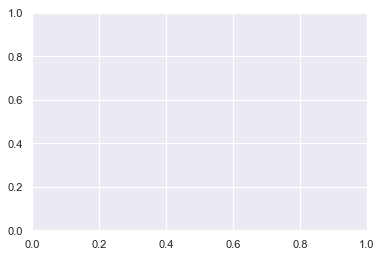

In [13]:
fig, ax = plt.subplots()
ax.scatter(data['x'], data['y'], c=data['color'])